In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import dask

import shapely
import geopandas as gpd
import salem

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def get_gdf_patch(coords_patch):
    # Replace each pair of points by 10 points for projected map
    geometry = []
    segments = zip(coords_patch[:-2:2], coords_patch[1:-1:2], coords_patch[2::2], 
                   coords_patch[3::2])
    
    for line in [shapely.geometry.LineString([(x1, y1), (x2, y2)]) for (x1,y1,x2,y2) in segments]:
        for length in np.linspace(0,1,11):
            geometry.append( line.interpolate(length, normalized=True) )
        
    gdf_patch = gpd.GeoDataFrame([], geometry=geometry)
    
    # Convert Points to Polygo
    gdf_patch['geometry'] = gdf_patch['geometry'].apply(lambda x: x.coords[0])
    
    gdf_patch['shape_id'] = 0
    gdf_patch = gdf_patch.groupby('shape_id')['geometry'].apply(lambda x: shapely.geometry.Polygon(x.tolist())).reset_index()
    gdf_patch = gpd.GeoDataFrame(gdf_patch, geometry = 'geometry')
    
    # Salem uses this attribute:
    gdf_patch.crs = {'init': 'epsg:4326'}
    
    return gdf_patch

In [3]:
main = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/').rename({'face': 'tile'})

In [4]:
# Volume (m^3)
vol = (main.rA*main.drF*main.hFacC).transpose('k','tile','j','i')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  


### Calculate section transports

In [5]:
coords_SB = [-53., 47.46182,-52., 47.46182,-51., 47.46182,-50., 47.46182,-50., 48.12596,-49., 48.12596,-48., 48.12596,
             -47., 48.12596,-46., 48.12596,-45., 48.12596,-44., 48.12596,-43., 48.12596,-42., 48.12596,-41., 48.12596,
             -40., 48.12596,-39., 48.12596,-38., 48.12596,-37., 48.12596,-36., 48.12596,-35., 48.12596,-34., 48.12596,
             -33., 48.12596,-33., 47.46182,-32., 47.46182,-31., 47.46182,-30., 47.46182,-29., 47.46182,-28., 47.46182,
             -27., 47.46182,-26., 47.46182,-26., 46.78843,-25., 46.78843,-24., 46.78843,-23., 46.78843,-22., 46.78843,
             -22., 46.105774,-21., 46.105774,-20., 46.105774,-19., 46.105774,-18., 46.105774,-18., 45.41385,
             -17., 45.41385,-16., 45.41385,-15., 45.41385,-15., 44.712654,-14., 44.712654,-13., 44.712654,
             -13., 44.0022,-12., 44.0022,-11., 44.0022,-10., 44.0022,-10., 43.282494,-9.,43.282494]
coords_SB_to_EC = [-1.,43.282494,-1.,48.78087]
coords_EC = [-5.,48.78087,-5.,50.063072]
coords_EC_to_FS = [-5.,51.917812,
                   -3.,51.917812,
                   -3.,56.470177]
coords_FS = [-5.0209107, 58.686825,-5.037469 , 59.2385  ,-5.0590353, 59.784798,-5.085762 , 60.325672,
             -5.1178174 , 60.861084,-6.125942 , 60.84489 ,-6.166107, 61.37257,-6.2123857, 61.894703]
coords_IF = [-7.2812705, 62.386726,-7.344147, 62.895226,-8.362914, 62.86655,-8.436943, 63.36676,-9.458087, 63.333656,
             -10.47765, 63.298805,-10.567438, 63.787502,-11.588718,63.747887,-11.691477, 64.22754,
             -12.714039, 64.18291,-13.733949, 64.13652,-13.853814, 64.6033]
coords_DeS = [-24.503857, 65.66525,-24.697086, 66.05268,-25.656406, 65.969666,-26.60553, 65.88757,-26.80609, 66.25563,
              -27.73846 , 66.169136 ,-27.949457 , 66.52263 ,-28.86185 , 66.431946 ,-29.760134 , 66.34398,
              -29.971338 , 66.6755 ,-30.843836 , 66.58435 ,-31.699657 , 66.49765,-31.904171 , 66.80529 ,
              -32.727146 , 66.71687 ,-32.934757 , 67.00616 ,-33.719128 , 66.91664]
coords_DaS = [-54.23812 , 66.30245 ,-55.23425 , 66.384575 ,-55.432312 , 65.97625 ,-56.435608 , 66.052315 ,
              -57.4459 , 66.127075 ,-58.462845 , 66.20026 ,-59.486107 , 66.27162 ,-60.515358 , 66.34096 ,
              -60.687084 , 65.90322 ,-61.71775 , 65.96633]
coords_DaS_to_HS = [-65.88552 , 66.14171 , -65.522354 , 63.298805 ]
coords_HS = [-65.74028 , 61.797977, -65.796906, 61.28634 , -65.84604 , 60.769142, -65.88795, 60.24646,
             -65.922874 , 59.71838]
coords_HS_to_LG = [-65.461975,58.910896,-60,54,-56.5,52.814613]
coords_LG_to_SB = [-56.5,48.454567,-53., 47.46182]
coords_DeS_to_FrS = [-34.48089 , 66.8355,-35.11053 , 67.57883,-20.932653 , 78.87449]
coords_FrS = [-19.186508 , 79.03997,-17.391916 , 79.19493,-15.550275 , 79.33904,-13.663382 , 79.47198,
              -11.733448 , 79.5934,-11.066698 , 79.211174,-9.158151 , 79.31644,-7.2162747 , 79.40999,
              -5.244295 , 79.49161,-3.2457807 , 79.561066,-1.224616 , 79.618164,-0.9266135 , 79.21572,
              1.0404158 , 79.2584,3.0199282 , 79.28907,5.007849 , 79.30747,7.0 , 79.31361,8.992151 , 79.30747,
              10.980072 , 79.28907]
coords_FrS_to_SvN = [16.877235 , 79.16097,16.069956,76.879066]
coords_SvN = [16.739313, 76.64243, 16.468266, 76.222755, 18.017347, 76.16335, 17.723822, 75.74302,
              17.448696, 75.31985, 18.910137, 75.25662, 18.618252, 74.83322, 18.34467, 74.40739, 19.729927, 74.3413,
              19.444464, 73.91592, 19.177204, 73.48885, 18.92733, 73.06082, 20.221594, 72.99534, 19.96517, 72.569916,
              19.726929, 72.14657, 20.968075, 72.07988, 20.731846, 71.66982, 20.513678, 71.26436, 20.307493, 70.85302,
              21.488281, 70.78876, 21.278511, 70.37436]
coords_SvN_to_SN = [21.080824 , 69.95405,20.894821 , 69.52784,7.0 , 61.499973]
coords_SN = [4.9789214 , 60.954185 ,3.9684584 , 60.95079 ,3.9770377 , 60.40301,2.9694877 , 60.398922,
             2.9789946 , 59.846252,1.9738591 , 59.84185,0.96880066 , 59.836487,0.9801969 , 59.280174,
             -0.022954563 , 59.27508,-0.012811167 , 58.714504,-1.0145311 , 58.710075,-1.0064105 , 58.145473,
             -2.00715 , 58.142113,-2.0017748 , 57.573742]
coords_SN_to_FS = [-2.5004644 , 57.28708, -3.500000, 56.736153, -4.500550, 57.284992, -5.0209107, 58.686825]
coords_LG = [-56.0, 53.69125,-55.0, 53.69125,-55.0, 54.264557,-55.0 ,54.829044,-54.0,54.829044,-54.0,55.384766,
             -53.0 , 55.384766,-53.0 , 55.931786,-52.0 , 55.931786,-52.0 , 56.470177,-51.0 , 56.470177,-51.0 , 57.0,
             -50.0 , 57.0,-49.997044 , 57.494728,-48.9972 , 57.491325,-48.98871 , 57.978825,-47.98942 , 57.972424,
             -46.990215,57.96642,-46.9778, 58.443645,-45.979767, 58.435368,-45.9637, 58.905373,-44.967514, 58.89538,
             -44.94873 , 59.35802,-43.955177 , 59.346916,-43.93474 , 59.802036]
coords_LG_to_DaS = [-43.808777 , 61.561226,-53.250584 , 66.21951]

In [7]:
#coords_spna = [-9.4, 50,-56.8, 50,-67.5, 62.3,-61.6, 66.7,-35, 66.7,-22.1, 66.1,-3.8, 59,-9.4, 50]
coords_spna = coords_SB+coords_SB_to_EC+coords_EC+coords_EC_to_FS+coords_FS+coords_IF+coords_DeS+coords_DaS+\
                coords_DaS_to_HS+coords_HS+coords_HS_to_LG+coords_LG_to_SB

#coords_nsea = [-3.8, 59,-22.1, 66.1,-35, 66.7,-29, 70,-25, 80,20, 80,20, 70,11, 64,5, 60,-3.8,59]
coords_nsea = coords_FS+coords_IF+coords_DeS+coords_DeS_to_FrS+coords_FrS+coords_FrS_to_SvN+coords_SvN+\
                coords_SvN_to_SN+coords_SN+coords_SN_to_FS

coords_lsea = coords_DaS+coords_DaS_to_HS+coords_HS+coords_HS_to_LG+coords_LG+coords_LG_to_DaS

In [8]:
gdf_spna = get_gdf_patch(coords_spna)
gdf_nsea = get_gdf_patch(coords_nsea)
gdf_lsea = get_gdf_patch(coords_lsea)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://

In [9]:
# Create mask for SPNA
df = main.coords.to_dataset().get(['XC','YC']).to_dataframe()
gdf = gpd.GeoDataFrame(df[[]],geometry=[shapely.geometry.Point(xy) for xy in zip(df.XC, df.YC)])

gdf['mask_spna'] = gdf.geometry.intersects(gdf_spna.iloc[0,1])
gdf['mask_nsea'] = gdf.geometry.intersects(gdf_nsea.iloc[0,1])
gdf['mask_lsea'] = gdf.geometry.intersects(gdf_lsea.iloc[0,1])

mask_spna = gdf[['mask_spna']].to_xarray().mask_spna.transpose('tile','j','i')
main['mask_spna'] = mask_spna.where(main.hFacC[0].values==1,0)

mask_nsea = gdf[['mask_nsea']].to_xarray().mask_nsea.transpose('tile','j','i')
main['mask_nsea'] = mask_nsea.where(main.hFacC[0].values==1,0)

mask_lsea = gdf[['mask_lsea']].to_xarray().mask_lsea.transpose('tile','j','i')
main['mask_lsea'] = mask_lsea.where(main.hFacC[0].values==1,0)

In [10]:
results = []

for mask in [main.mask_spna,main.mask_nsea,main.mask_lsea]:
    
    # Total volume (m^3)
    V = (vol*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    results.append(dask.compute(V))

In [27]:
results[0][0].values/results[1][0].values

3.8758450092909937

In [28]:
results[0][0].values/results[2][0].values

10.017224664189186

#### Save to netcdf

In [37]:
ds = budg_fw.reset_coords(drop=True).to_dataset(name='budg_fw')

In [38]:
ds.to_netcdf('/mnt/efs/data/ecco/ecco_budg_fw_Sref300.nc', format='NETCDF4')

In [39]:
ds.budg_fw

<xarray.DataArray 'budg_fw' (region: 3, term: 6, time: 288)>
array([[[ 0.00000000e+00,  8.86477243e-02,  2.66462721e-01, ...,
         -1.04682133e-01, -1.31579349e-01,  0.00000000e+00],
        [ 1.26269468e-01,  1.17779382e-01,  2.10910150e-01, ...,
          8.89853863e-02,  1.09996759e-02,  7.13956166e-02],
        [-1.14206822e-01,  4.47121160e-02,  1.40252333e-01, ...,
         -1.43674416e-01, -8.59531978e-02, -1.48913210e-01],
        [-1.14206822e-01,  4.47121160e-02,  1.40252333e-01, ...,
         -1.43674416e-01, -8.59531978e-02, -1.48913210e-01],
        [ 1.20626452e-02,  1.62491498e-01,  3.51162483e-01, ...,
         -5.46890294e-02, -7.49535219e-02, -7.75175936e-02],
        [-2.62099947e+09, -2.62100516e+09, -2.62060011e+09, ...,
         -2.62006715e+09, -2.62042456e+09, -2.62069017e+09]],

       [[ 0.00000000e+00, -4.67939282e-02, -3.14063266e-02, ...,
         -3.66970087e-02, -5.96067893e-02,  0.00000000e+00],
        [ 3.66102527e-02,  6.68051478e-02,  4.78285923e-02, ...,
          2.04487571e-02,  2.04024715e-02,  7.79695881e-02],
        [-1.87199672e-02, -6.68830752e-02, -4.31396431e-02, ...,
         -3.26182922e-02, -2.55367784e-02, -1.09922167e-01],
        [-1.87199672e-02, -6.68830752e-02, -4.31396431e-02, ...,
         -3.26182922e-02, -2.55367784e-02, -1.09922167e-01],
        [ 1.78902854e-02, -7.79273835e-05,  4.68894919e-03, ...,
         -1.21695351e-02, -5.13430691e-03, -3.19525787e-02],
        [-6.66775139e+08, -6.66825329e+08, -6.66908219e+08, ...,
         -6.71539296e+08, -6.71667946e+08, -6.71824685e+08]],

       [[ 0.00000000e+00, -7.72346904e-02, -1.41390875e-02, ...,
         -4.94178623e-02, -6.19336239e-02,  0.00000000e+00],
        [-6.13705814e-03, -8.34947313e-03,  5.28265510e-02, ...,
          4.53681124e-03, -2.05473414e-02, -1.65341728e-02],
        [-7.30692480e-02, -6.05696097e-02, -6.01242123e-02, ...,
         -5.72607778e-02, -4.36033332e-02, -5.21156607e-02],
        [-7.30692480e-02, -6.05696097e-02, -6.01242123e-02, ...,
         -5.72607778e-02, -4.36033332e-02, -5.21156607e-02],
        [-7.92063062e-02, -6.89190829e-02, -7.29766124e-03, ...,
         -5.27239666e-02, -6.41506746e-02, -6.86498335e-02],
        [-2.52312434e+08, -2.52543499e+08, -2.52698427e+08, ...,
         -2.52862989e+08, -2.53019044e+08, -2.53194748e+08]]])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14T12:00:00
  * term     (term) object 'tendFw' 'forcFw' 'adv_ConvFw' ... 'totalFw' 'lfwc'
  * region   (region) object 'spna' 'nsea' 'lsea'

In [41]:
from datetime import date

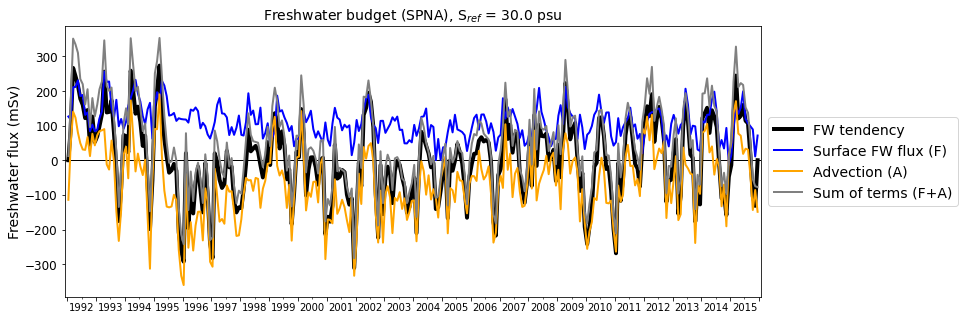

In [42]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Freshwater budget (SPNA), S$_{ref}$ = 30.0 psu',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='tendFw')*1e3, lw=4, color='black',label='FW tendency')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='forcFw')*1e3, lw=2, color='blue',label='Surface FW flux (F)')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='adv_ConvFw')*1e3, lw=2, color='orange',label='Advection (A)')
#ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='dif_ConvFw')*1e3, lw=2, color='purple',label='Diffusion')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='totalFw')*1e3, lw=2, color='grey',label='Sum of terms (F+A)')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([date(1991, 12, 1), date(2016, 2, 1)])

ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)
#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

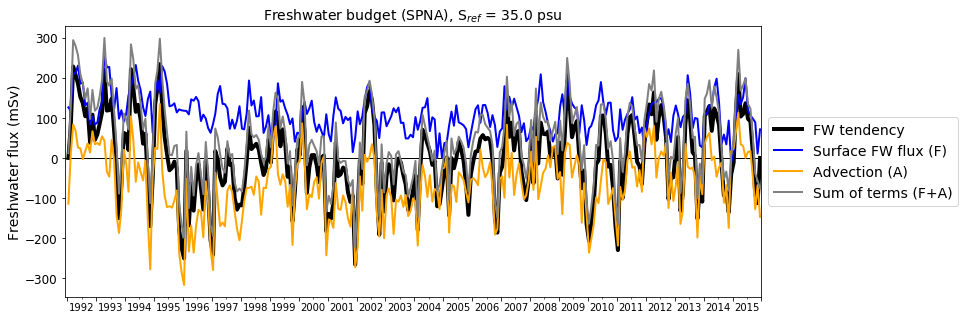

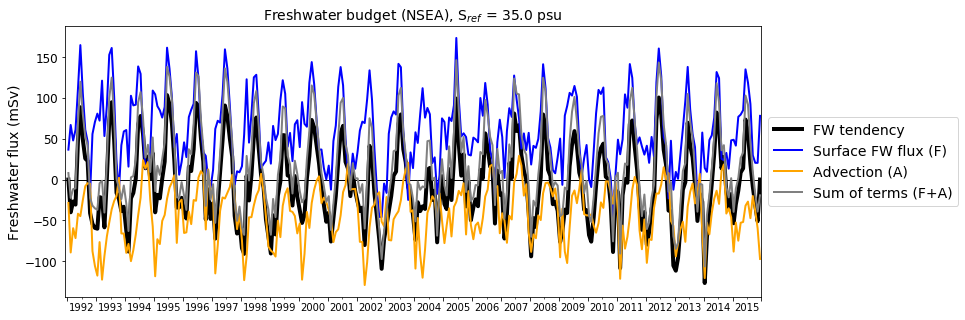

In [53]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Freshwater budget (NSEA), S$_{ref}$ = 35.0 psu',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term='tendFw')*1e3, lw=4, color='black',label='FW tendency')
ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term='forcFw')*1e3, lw=2, color='blue',label='Surface FW flux (F)')
ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term='adv_ConvFw')*1e3, lw=2, color='orange',label='Advection (A)')
#ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='dif_ConvFw')*1e3, lw=2, color='purple',label='Diffusion')
ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term='totalFw')*1e3, lw=2, color='grey',label='Sum of terms (F+A)')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)
#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

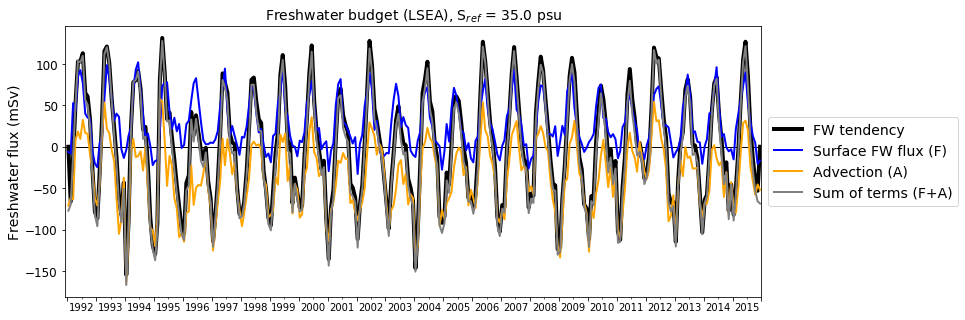

In [54]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Freshwater budget (LSEA), S$_{ref}$ = 35.0 psu',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='lsea',term='tendFw')*1e3, lw=4, color='black',label='FW tendency')
ax.plot(budg_fw.time, budg_fw.sel(region='lsea',term='forcFw')*1e3, lw=2, color='blue',label='Surface FW flux (F)')
ax.plot(budg_fw.time, budg_fw.sel(region='lsea',term='adv_ConvFw')*1e3, lw=2, color='orange',label='Advection (A)')
#ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='dif_ConvFw')*1e3, lw=2, color='purple',label='Diffusion')
ax.plot(budg_fw.time, budg_fw.sel(region='lsea',term='totalFw')*1e3, lw=2, color='grey',label='Sum of terms (F+A)')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)
#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

**Default section transports (Boundary fluxes)**

- 'Newfoundland Iberia': into *SPNA*
- 'English Channel': into *SPNA*
- 'Hudson Strait': out of *SPNA* (and out of *LSEA*)
- 'Davis Strait': out of *SPNA* (and out of *LSEA*)
- 'Denmark Strait': out of *SPNA* and into *NSEA*
- 'Iceland Faroe': out of *SPNA* and into *NSEA*
- 'Faroe Scotland': out of *SPNA* and into *NSEA*
- 'Scotland Norway': out of *NSEA*
- 'Fram Strait': out of *NSEA*
- 'Barents Sea': out of *NSEA*
- 'Labrador Greenland': into *LSEA*

In [39]:
ConvFw_spna_bnd = fw_trsp.sel(section='Newfoundland Iberia') + fw_trsp.sel(section='English Channel') \
                    - fw_trsp.sel(section='Hudson Strait') - fw_trsp.sel(section='Davis Strait') \
                    - fw_trsp.sel(section='Denmark Strait') - fw_trsp.sel(section='Iceland Faroe') \
                    - fw_trsp.sel(section='Faroe Scotland')

In [46]:
ConvFw_nsea_bnd = fw_trsp.sel(section='Denmark Strait') + fw_trsp.sel(section='Iceland Faroe') \
                    + fw_trsp.sel(section='Faroe Scotland') + fw_trsp.sel(section='Scotland Norway') \
                    - fw_trsp.sel(section='Fram Strait') - fw_trsp.sel(section='Barents Sea')

In [41]:
ConvFw_lsea_bnd = fw_trsp.sel(section='Labrador Greenland') - fw_trsp.sel(section='Hudson Strait') \
                    - fw_trsp.sel(section='Davis Strait')

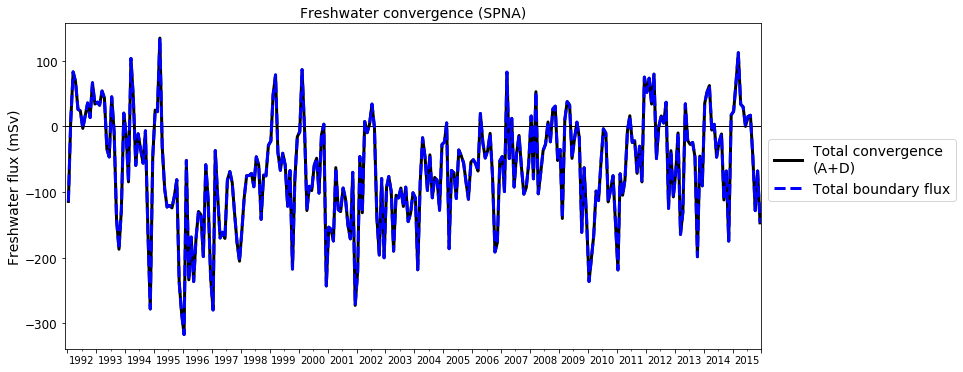

In [42]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Freshwater convergence (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='ConvFw')*1e3, lw=3, color='k',
        label='Total convergence\n(A+D)')
ax.plot(ConvFw_spna_bnd.time, ConvFw_spna_bnd*1e3, lw=3, color='b',ls='--',label='Total boundary flux')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

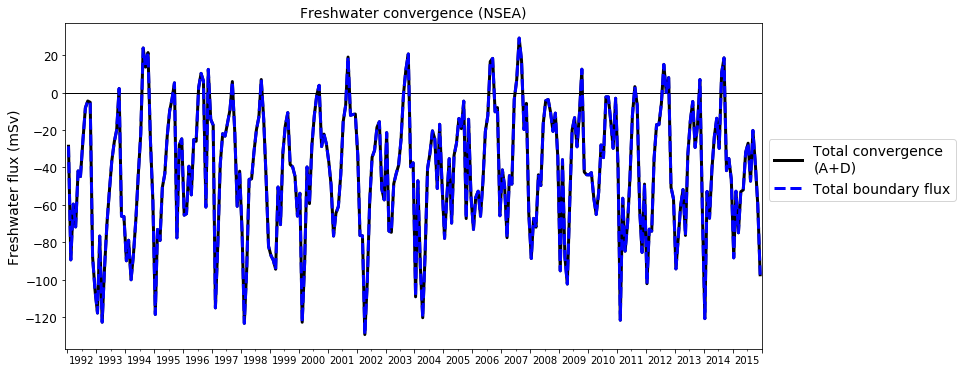

In [47]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Freshwater convergence (NSEA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term='ConvFw')*1e3, lw=3, color='k',
        label='Total convergence\n(A+D)')
ax.plot(ConvFw_nsea_bnd.time, ConvFw_nsea_bnd*1e3, lw=3, color='b',ls='--',label='Total boundary flux')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

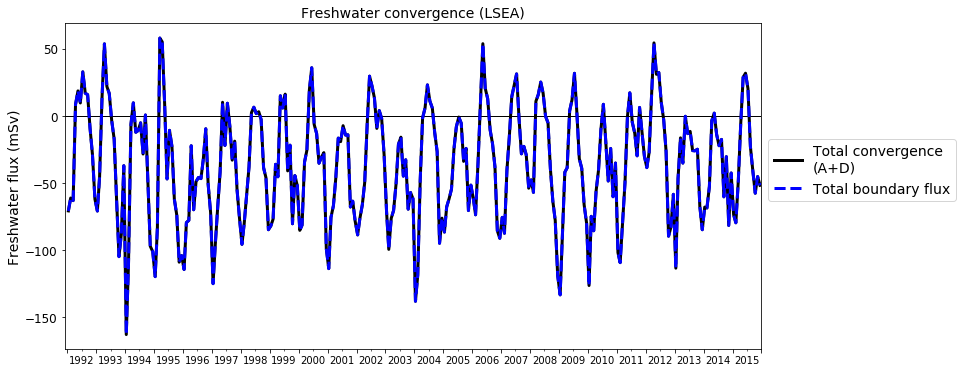

In [45]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Freshwater convergence (LSEA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='lsea',term='ConvFw')*1e3, lw=3, color='k',
        label='Total convergence\n(A+D)')
ax.plot(ConvFw_lsea_bnd.time, ConvFw_lsea_bnd*1e3, lw=3, color='b',ls='--',label='Total boundary flux')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

In [70]:
v1 = budg_fw.sel(region='spna',term='lfwc') - budg_fw.sel(region='spna',term='lfwc').mean('time')

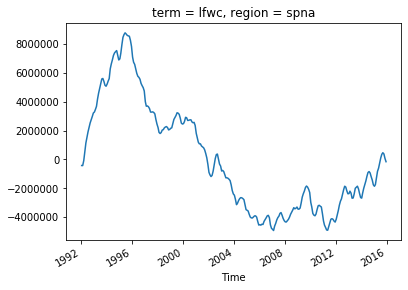

In [71]:
v1.plot()

In [73]:
v2 = lfwc_spna_ec_monthly.lfwc - lfwc_spna_ec_monthly.lfwc.mean('tim')

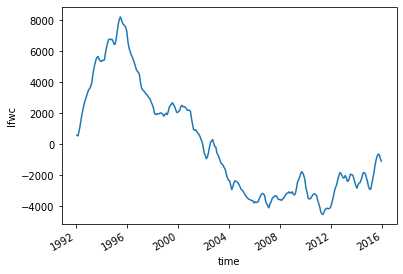

In [74]:
v2.plot()

No handles with labels found to put in legend.


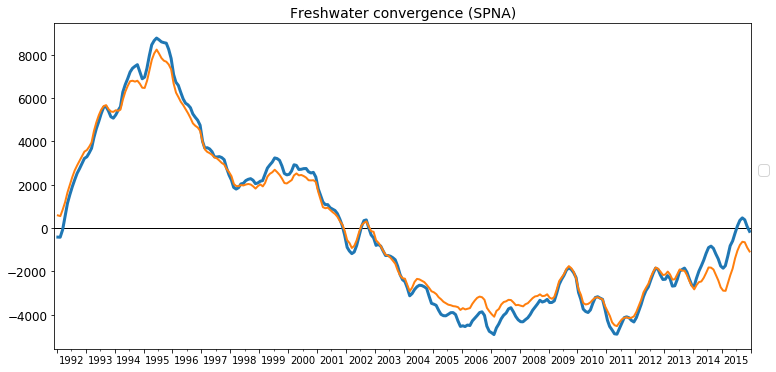

In [77]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Freshwater convergence (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(v1.time, v1*1e-3, lw=3)
ax.plot(v2.tim, v2, lw=2)

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

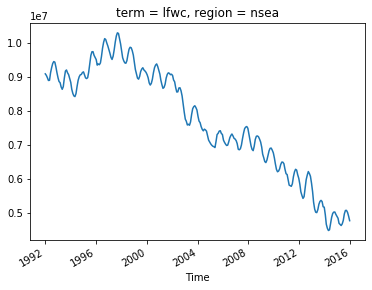

In [57]:
budg_fw.sel(region='nsea',term='lfwc').plot()

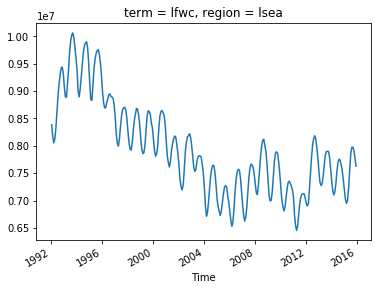

In [58]:
budg_fw.sel(region='lsea',term='lfwc').plot()

In [59]:
lfwc_spna_ec_monthly = xr.open_dataset('/mnt/efs/data/ecco/ecco_lfwc_spna_monthly.nc')
lfwc_nsea_ec_monthly = xr.open_dataset('/mnt/efs/data/ecco/ecco_lfwc_nsea_monthly.nc')